In [5]:
import os
import json
import glob
import shutil
import cv2
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [6]:
degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg', '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']

In [94]:
json_="../2_json"
occlusion_result = "../9_occlusion_result"
occlusion = "../9_occlusion_image"
occlusion_localization_error = "../9_occlusion_localization_error"

cm = [4.72, 4.74, 3.9, 3.91, 4.20, 4.60, 4.69, 4.75]


names = os.listdir(mmpose_result)

for n in range(0,len(names)):


    for deg in degrees:
        gt_json = os.path.join(json_, names[n], deg, "keypoint_location.json")
        with open(gt_json, "r") as gt_f:
            gt_all = json.load(gt_f)
        
        
        
        
        for frame_index in os.listdir(os.path.join(occlusion_result, names[n], deg)):
            
            if not os.path.isdir(os.path.join(occlusion_localization_error, names[n], deg, frame_index)):
                os.makedirs(os.path.join(occlusion_localization_error, names[n], deg, frame_index))
        
            occlusion_result_name_deg_frame_index = os.path.join(occlusion_result, names[n], deg, frame_index)
            result_name_deg_frame_index = os.path.join(mmpose_result, names[n], "localization_error", deg, frame_index)
        
            results = os.listdir(occlusion_result_name_deg_frame_index)
            results = sorted(results, key = lambda s : int(re.split("[_|.]",os.path.basename(s))[1]), reverse = False)

            for occl_index in results:
                pred_json = os.path.join(occlusion_result_name_deg_frame_index, occl_index)
                with open(pred_json, "r") as pred_f:
                    pred = json.load(pred_f)
                    

                scale0_x = float(gt_all["frame_{index}".format(index = frame_index)]["0"]["keypoint_location"][0])
                scale0_y = float(gt_all["frame_{index}".format(index = frame_index)]["0"]["keypoint_location"][1])

                scale11_x = float(gt_all["frame_{index}".format(index = frame_index)]["11"]["keypoint_location"][0])
                scale11_y = float(gt_all["frame_{index}".format(index = frame_index)]["11"]["keypoint_location"][1])

                scale = cm[n] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))
                
                
                
            
                all_kpts = {}
                for i in range(0, len(gt_all["frame_{index}".format(index = frame_index)])):
                    if gt_all["frame_{index}".format(index = frame_index)][str(i)]["keypoint_location"][0] != -1 and gt_all["frame_{index}".format(index = frame_index)][str(i)]["keypoint_location"][1] != -1:
                        all_kpts[i] = []
                        gt_x_y = (gt_all["frame_{index}".format(index = frame_index)][str(i)]["keypoint_location"][0], gt_all["frame_{index}".format(index = frame_index)][str(i)]["keypoint_location"][1])
                        pred_x_y = (pred["instance_info"][0]["keypoints"][i][0], pred["instance_info"][0]["keypoints"][i][1])

                        all_kpts[i].append(scale * dist(gt_x_y, pred_x_y))
                    else:
                        all_kpts[i] = []
                        
                with open(os.path.join(occlusion_localization_error, names[n], deg, frame_index, occl_index), "w") as f_occlusion_localization_error:
                    json.dump(all_kpts, f_occlusion_localization_error)
                






    
            
        

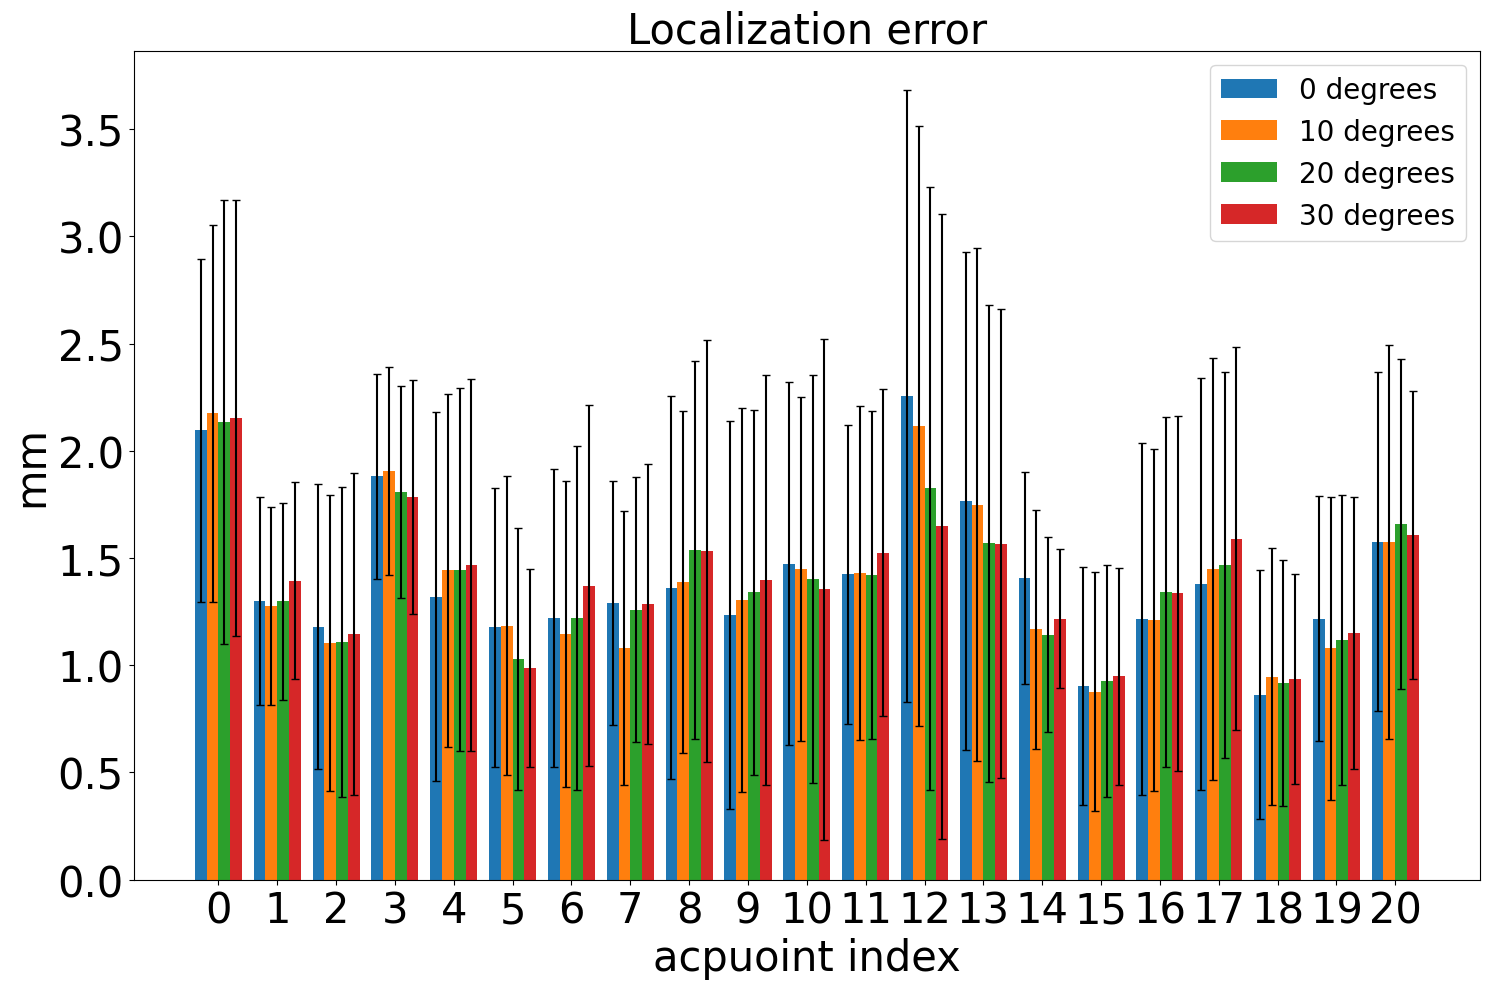

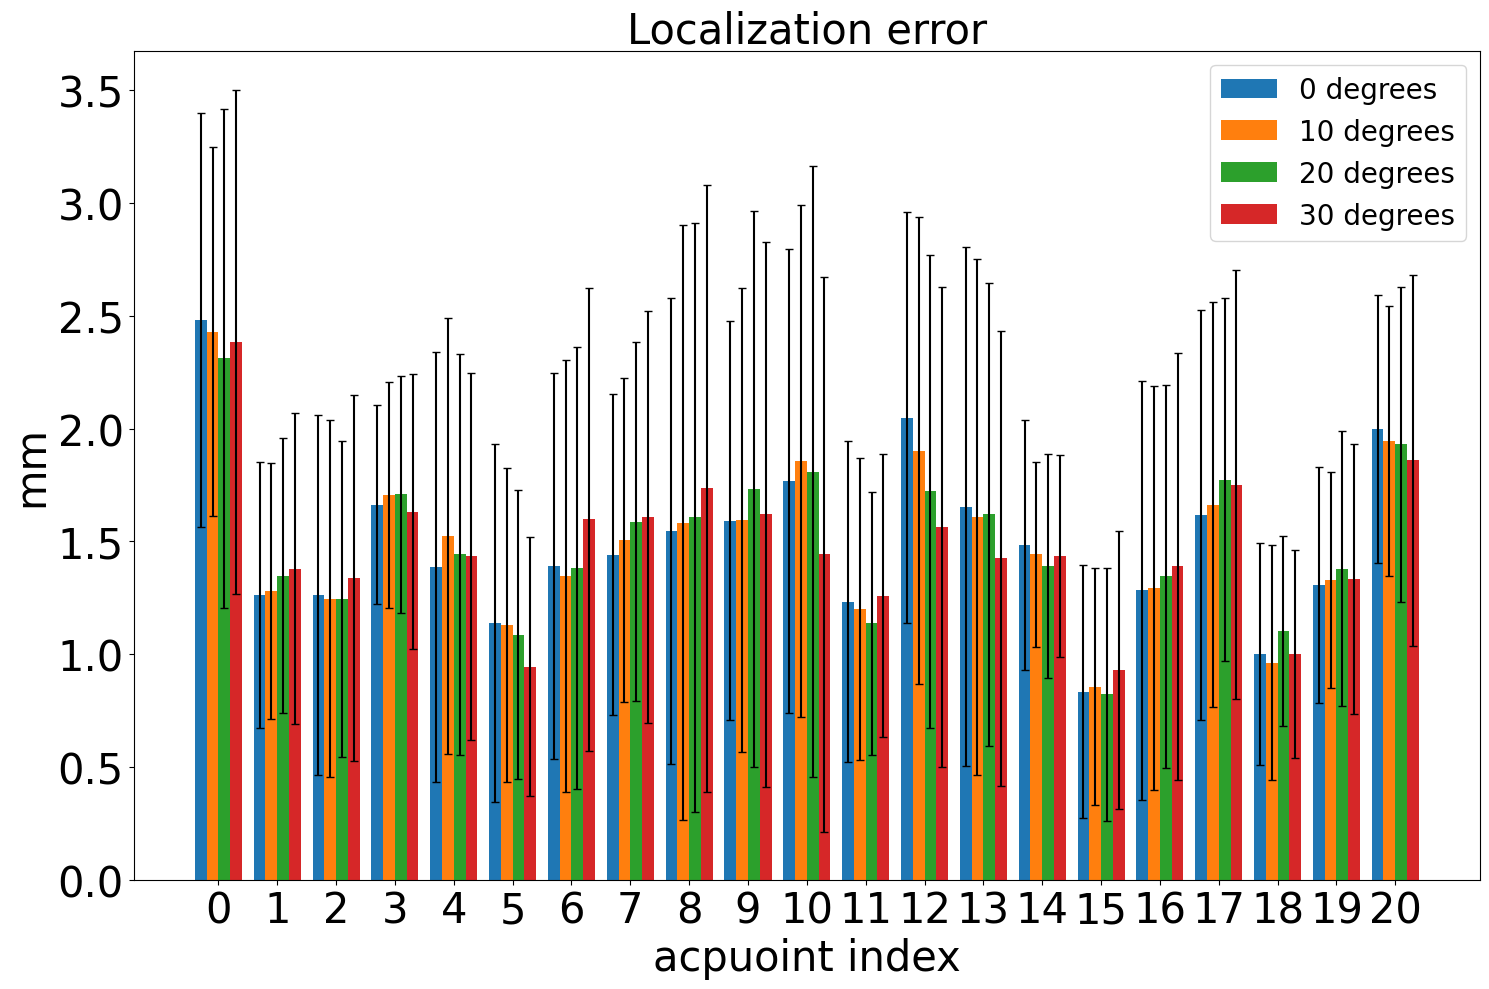

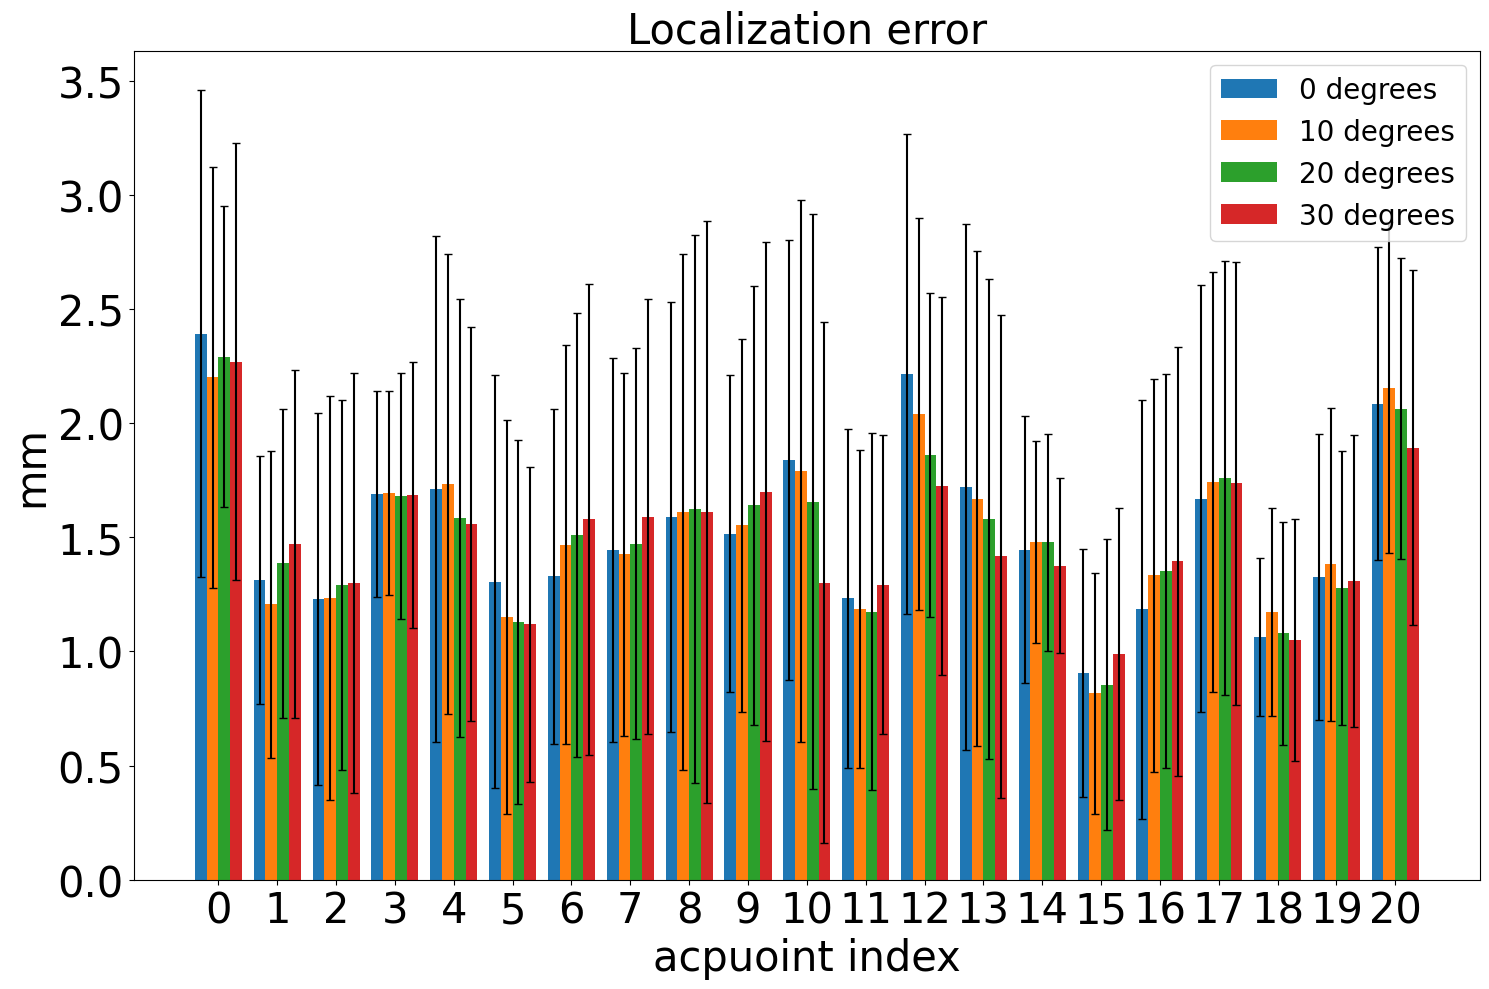

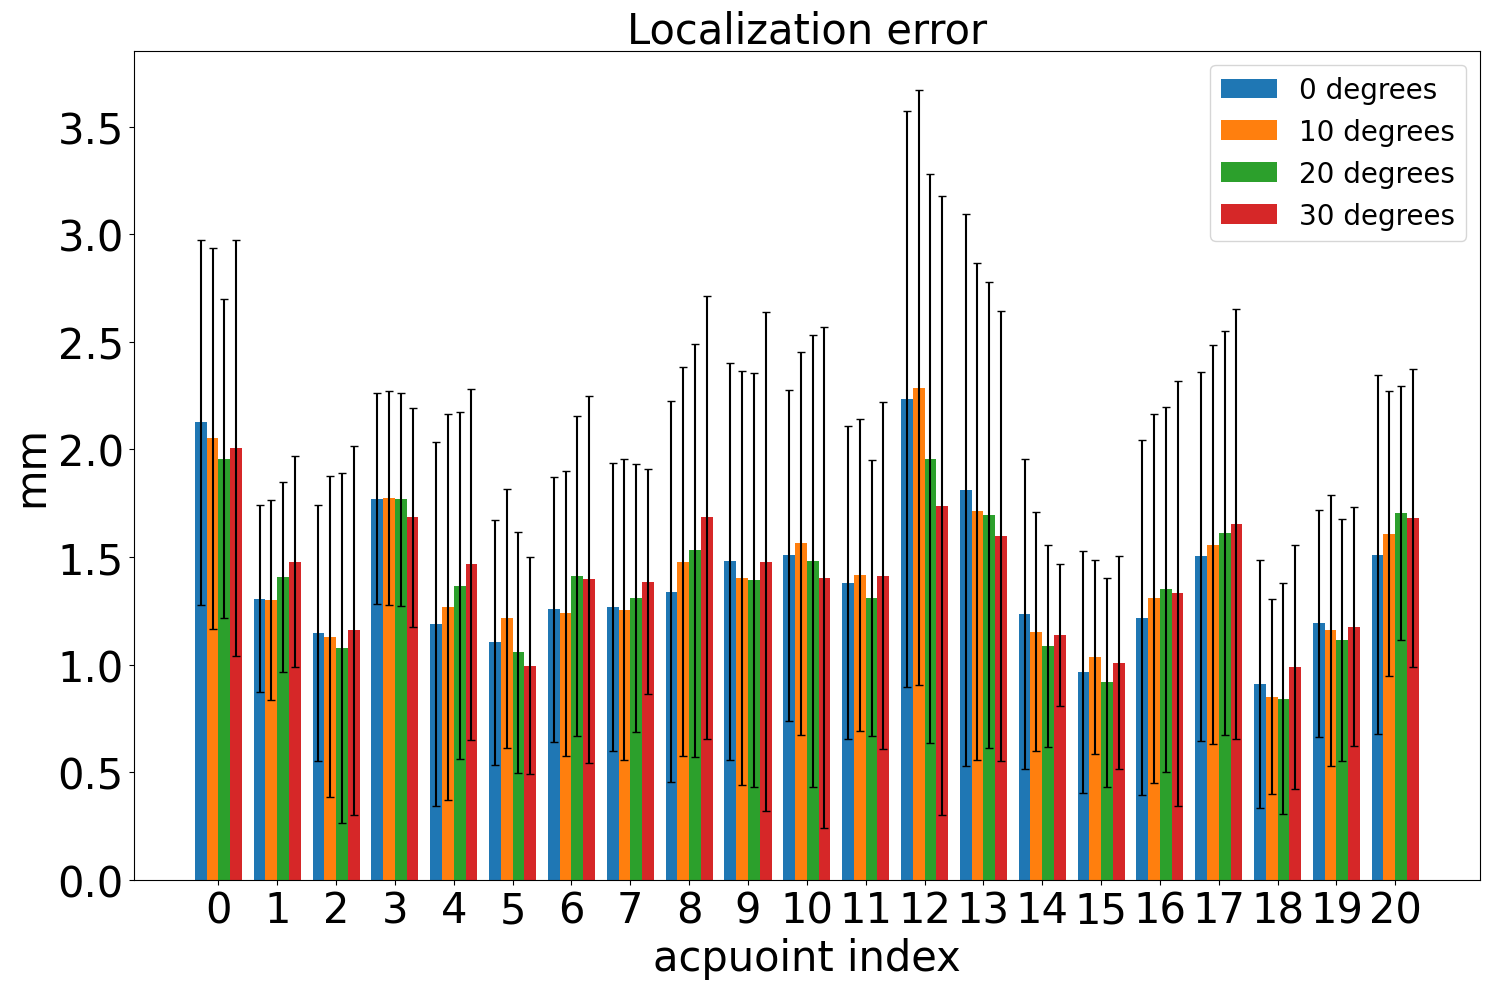

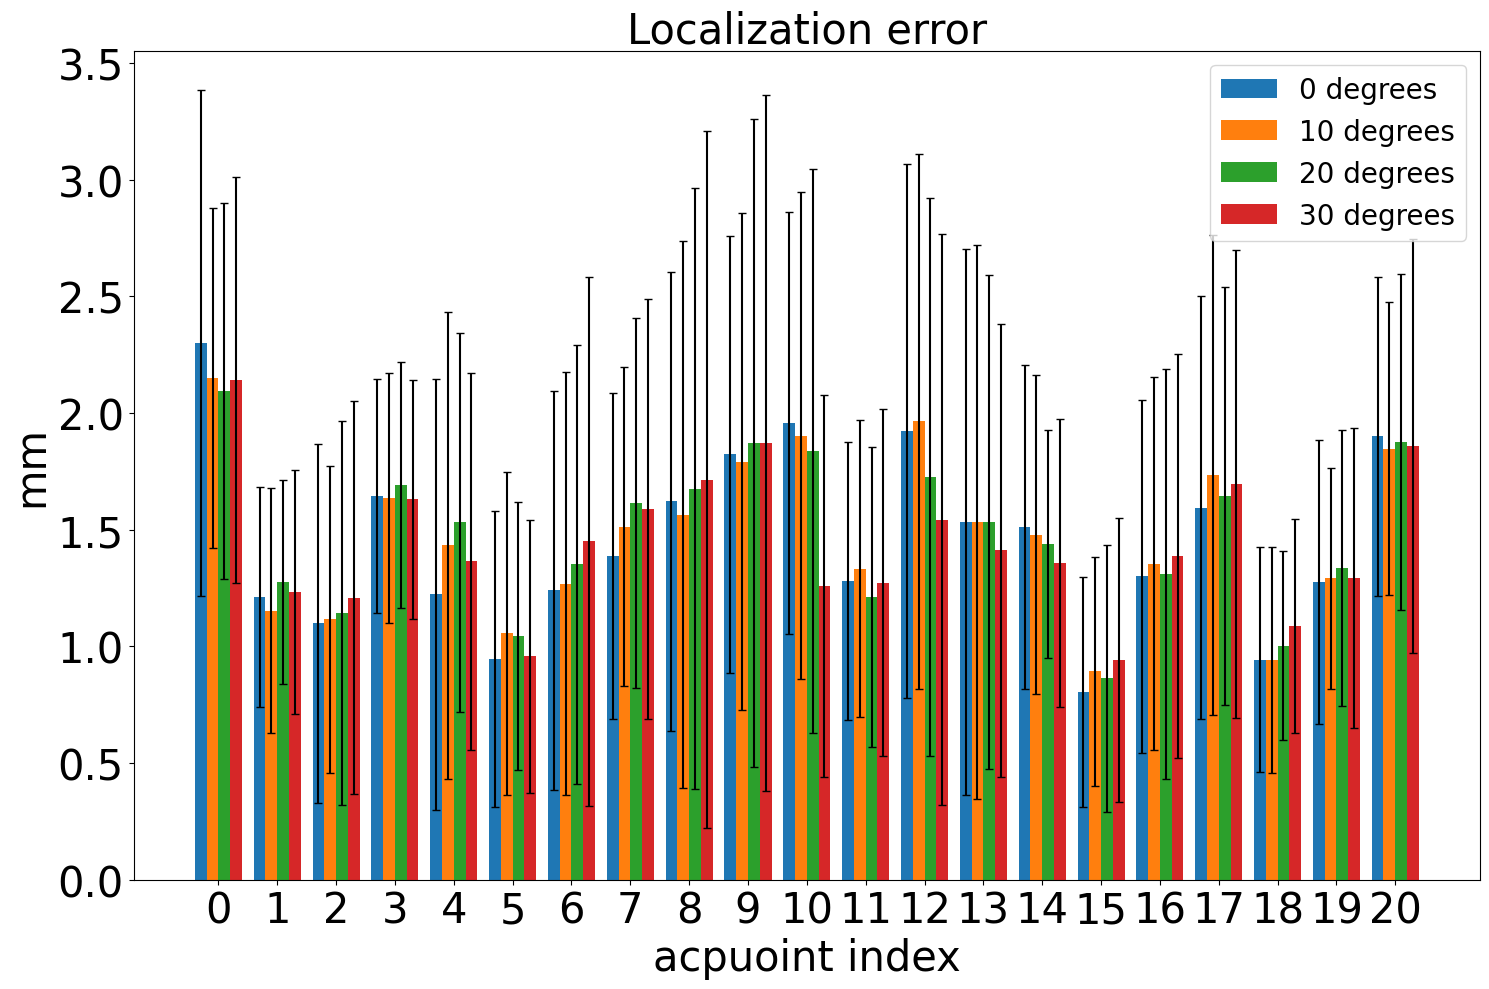

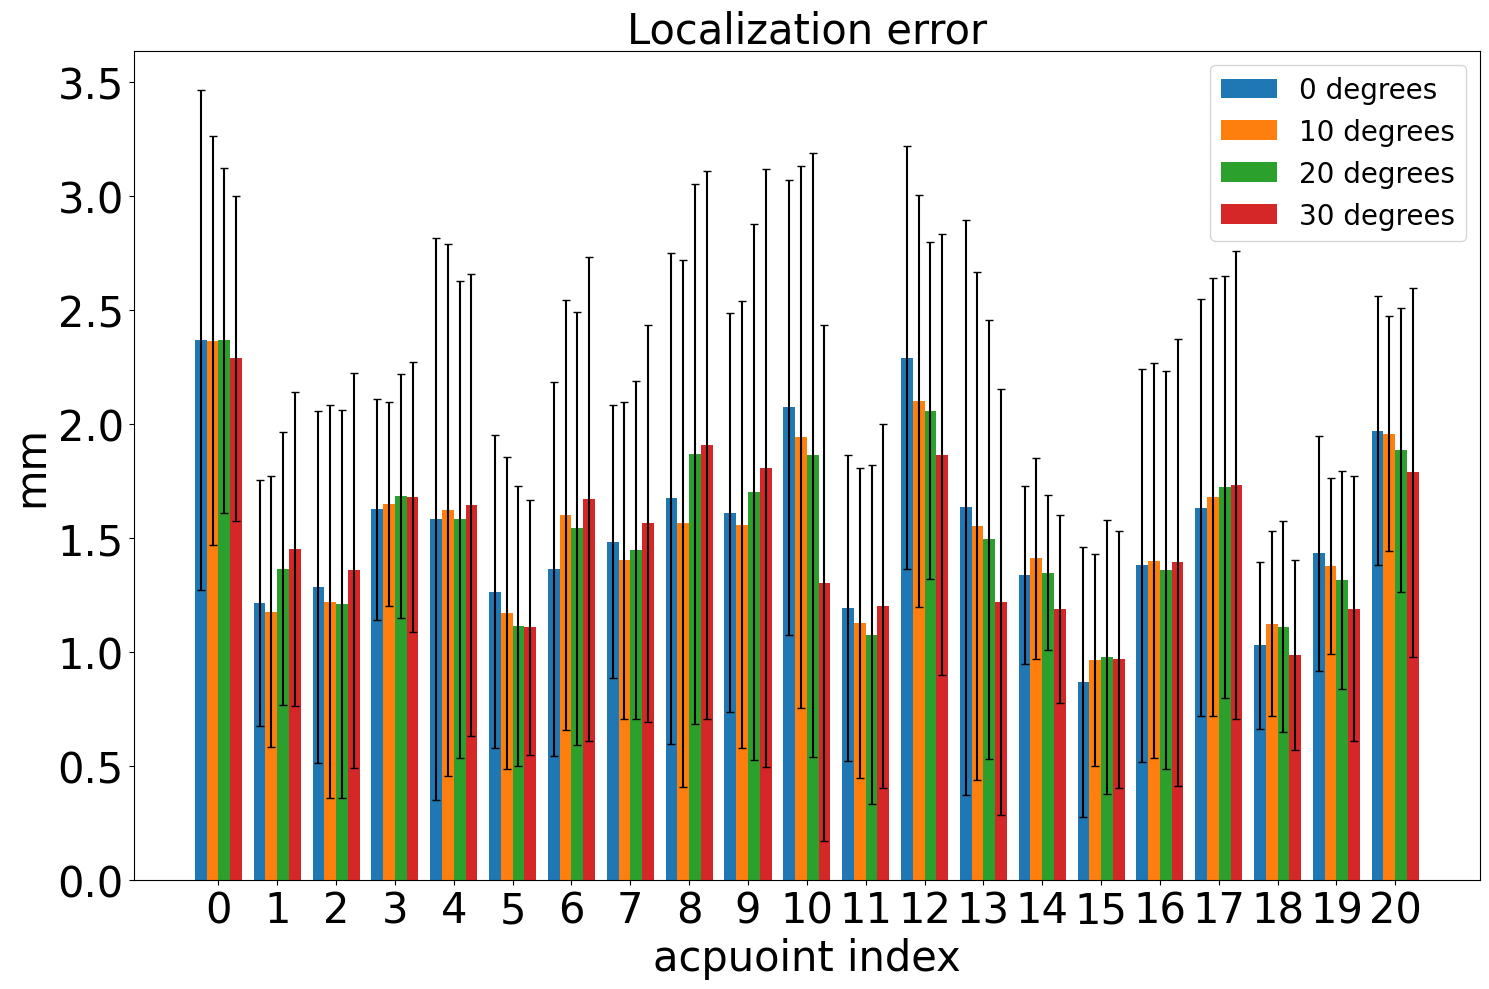

In [97]:
json_="../2_json"
occlusion_result = "../9_occlusion_result"
occlusion = "../9_occlusion_image"
occlusion_localization_error = "../9_occlusion_localization_error"
final = "../7_final"
names = os.listdir(mmpose_result)

angles = len(os.listdir("../9_occlusion_localization_error/cather/15cm_0mm_0deg"))


differen_angle = {}
for k in range(0,4):
    differen_angle[k] = {}
    for l in range(0,21):
        differen_angle[k][l] = []



        
        
for deg in degrees:

    differen_angle = {}
    for k in range(0,4):
        differen_angle[k] = {}
        for l in range(0,21):
            differen_angle[k][l] = []
    
    means = []
    stds = []
    
    for name in names:
        mean = []
        std = []
        
        occlusion_localization_error_name_deg = os.path.join(occlusion_localization_error, name, deg)
        
        angles = os.listdir(occlusion_localization_error_name_deg)
        angles = sorted(angles, key = lambda s : int(s), reverse = False)
        
        for i in range(0, len(angles)):
#             print(occlusion_localization_error_name_deg[i])
            occlusion_localization_error_name_deg_frame_index = os.path.join(occlusion_localization_error_name_deg, angles[i])
            files = os.listdir(occlusion_localization_error_name_deg_frame_index)
            files = sorted(files , key = lambda s : int(re.split("[_|.]",os.path.basename(s))[1]), reverse = False)
            
            for acu_no in range(0, len(files)):
                file = os.path.join(occlusion_localization_error_name_deg_frame_index, files[acu_no])

                with open(file,"r") as f:
                    error_f = json.load(f)
                
                if error_f[str(acu_no)] != []:
                    differen_angle[i][acu_no].append(error_f[str(acu_no)][0])
    means = []
    stds = []
    for i in range(0,len(differen_angle)):
        mean = []
        std = []
        for j in range(0, len(differen_angle[i])):
            acupoint_errors = np.array(differen_angle[i][j])
            mean.append(np.mean(acupoint_errors)*10.00)
            std.append(np.std(acupoint_errors)*10.00)

        means.append(mean)
        stds.append(std)
    
        
    plt.figure(figsize=(15,10))
    for l in range(0 ,len(means)):

        plt.bar(np.arange(21) + l*0.2, means[l], yerr=stds[l], align='center', label = '{index} degrees'.format(index = 0 + 10*l), ecolor='black', capsize=3, width=0.2)
    
    plt.xlabel('acpuoint index' , fontsize = 30)
    plt.ylabel('mm' , fontsize = 30)

    plt.xticks(np.arange(21) + 0.3, [str(x) for x in list(range(0 , 21))], fontsize=30)
    
    
    plt.yticks(fontsize=30)
    plt.title('Localization error', fontsize = 30)

    plt.legend(fontsize=20)

    plt.tight_layout()
    plt.savefig(os.path.join(final, deg,'occlusion_{index}.png').format(index = 0))
    plt.show()


[0.208458736631256, 0.12619645877401342, 0.11420562403790152, 0.15658593256556116, 0.1506929969608419, 0.10923631678221563, 0.14035746138252778, 0.13374997990551624, 0.14518637260409828, 0.15566016443924993, 0.1586967046663314, 0.12233071339209871, 0.19256532153460323, 0.14453100771166283, 0.12707024380416848, 0.0877644765340863, 0.12995564855244573, 0.1633006184919711, 0.10629986756406062, 0.12527149029450016, 0.17533193878716669]


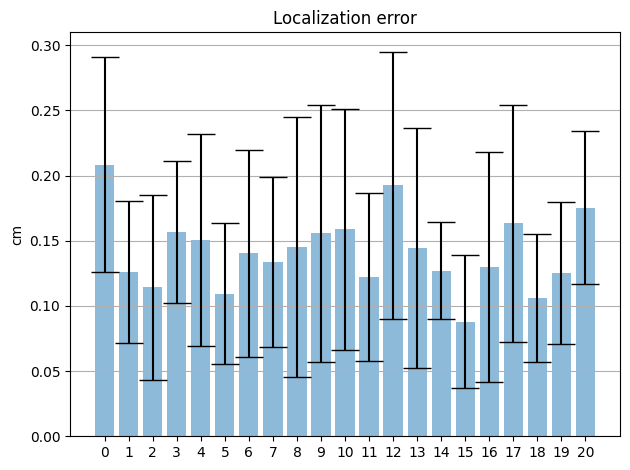

In [8]:
mmpose_result="../../../mmpose/result"

all_name_acu = {}
for i in range(0 ,21):
    all_name_acu[i] = []
for name in os.listdir(mmpose_result):
    mmpose_result_name = os.path.join(mmpose_result, name)
    mmpose_result_name_localization_error = os.path.join(mmpose_result_name, "localization_error")
    with open(os.path.join(mmpose_result_name_localization_error, "localization_error.json"), "r") as localization_error_file:
        localization_error = json.load(localization_error_file)

    for i in range(0 ,len(localization_error)):
        acupoints = np.array(localization_error[str(i)])
        all_name_acu[i].append(np.mean(acupoints))

mean = []
std = []
for i in range(0 ,len(localization_error)):
    mean.append(np.mean(np.array(all_name_acu[i])))
    std.append(np.std(np.array(all_name_acu[i])))

print(mean)
fig, ax = plt.subplots()
ax.bar(np.arange(21), mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('cm')
ax.set_xticks(np.arange(21))
ax.set_xticklabels(list(range(0, 21)))
ax.set_title('Localization error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [21]:

mmpose_result="../../../mmpose/result"
original_video = "../0_original_video"
cm = [4.72, 4.74, 3.9, 3.91, 4.20, 4.60, 4.69, 4.75]
names = os.listdir(mmpose_result)

for n in range(0, len(names)):

    mmpose_result_name = os.path.join(mmpose_result, names[n])
    files = glob.glob(os.path.join(mmpose_result_name, "*.json"))
    files = sorted(files, key= lambda s: int(os.path.splitext(os.path.basename(s))[0][5:]), reverse= False)
    
    mmpose_result_name_5_test_json = os.path.join(mmpose_result_name, "5_test_json")
    test_json = os.path.join(mmpose_result_name_5_test_json, "test.json")
    with open(test_json, "r") as file:
        gt_json = json.load(file)

    
    count = 0
    x=0
    for deg in degrees:
        
        resized_video = os.path.join(original_video, names[n], deg, "resize.mp4")
        cap = cv2.VideoCapture(resized_video)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        x = x + frame_count

        for i in range(0, frame_count):

            
            all_kpts = {}    
            for k in range(0, 21):
                all_kpts[k] = []
            
            mmpose_result_name_img_pre_json = os.path.join(mmpose_result_name, files[count])
            with open(mmpose_result_name_img_pre_json, "r") as pre_file:
                pre_json = json.load(pre_file)

            pre_keypoints = pre_json["instance_info"][0]["keypoints"]
            gt_keypoints = gt_json["annotations"][count]




            scale0_x = float(gt_keypoints["keypoints"][0])
            scale0_y = float(gt_keypoints["keypoints"][1])

            scale11_x = float(gt_keypoints["keypoints"][33])
            scale11_y = float(gt_keypoints["keypoints"][34])

            scale = cm[n] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))

            for j in range(0, len(pre_keypoints)):

                if gt_keypoints["keypoints"][3*j + 2 ] == 2:
                    pre_x = pre_keypoints[j][0]
                    pre_y = pre_keypoints[j][1]

                    gt_x = float(gt_keypoints["keypoints"][3*j])
                    gt_y = float(gt_keypoints["keypoints"][3*j + 1])

                    all_kpts[j].append(scale * dist((gt_x, gt_y), (pre_x, pre_y)))
               
            
        
            mmpose_result_name_localization_error = os.path.join(mmpose_result_name, "localization_error", deg)
            if not os.path.isdir(mmpose_result_name_localization_error):
                os.makedirs(mmpose_result_name_localization_error)
            with open(os.path.join(mmpose_result_name_localization_error, "test_{index}.json".format(index = i)), "w") as localization_error_file:
                json.dump(all_kpts, localization_error_file)
            count += 1
    
            
        

In [29]:
result="../7_result"
occlusion_result = "../9_occlusion_result"
occlusion_error = "../9_occlusion_localization_error"
occlusion_image= "../9_occlusion_image"
cm = [4.72, 4.74, 3.9, 3.91, 4.20, 4.60, 4.69, 4.75]
names = os.listdir(result)
cm_index = 0
for name in names:
 
    
    for deg in degrees:
        df = pd.DataFrame()
        result_name_ground_truth_deg = os.path.join(result, name, "ground_truth",deg)
        gt = glob.glob(os.path.join(result_name_ground_truth_deg, "*.csv"))[0]
        gt_df = pd.read_csv(gt,index_col = 0)
        
        
        frame_index_list = sorted(os.listdir(os.path.join(occlusion_result, name, deg)), key = lambda s : int(s), reverse = False)
        
        for frame_index in frame_index_list:
            
            occlusion_result_name_deg_frame_index = os.path.join(occlusion_result, name, deg, frame_index)
            occlusion_pred = glob.glob(os.path.join(occlusion_result_name_deg_frame_index, "*.csv"))[0]
            occlusion_pred_df = pd.read_csv(occlusion_pred, index_col = 0)
            

            scale0_x = float(gt_df.iloc[int(frame_index),0].split(",")[0])
            scale0_y = float(gt_df.iloc[int(frame_index),0].split(",")[1])

            scale11_x = float(gt_df.iloc[int(frame_index),11].split(",")[0])
            scale11_y = float(gt_df.iloc[int(frame_index),11].split(",")[1])

            scale = cm[cm_index] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))
                
            error = {}
            for j in range(0, len(occlusion_pred_df.columns)):
                if gt_df.iloc[int(frame_index),j].split(",")[2] == "2":
                    pred_x = float(occlusion_pred_df.iloc[0,j].split(",")[0])
                    pred_y = float(occlusion_pred_df.iloc[0,j].split(",")[1])

                    gt_x = float(gt_df.iloc[int(frame_index),j].split(",")[0])
                    gt_y = float(gt_df.iloc[int(frame_index),j].split(",")[1])
                   
                    error[j] = scale * dist((gt_x, gt_y), (pred_x, pred_y))
              
            occlusion_error_df = pd.DataFrame(error, index = [int(frame_index)], columns = list(range(0,len(occlusion_pred_df.columns))))

            df = pd.concat([df,occlusion_error_df])

        if not os.path.isdir(os.path.join(occlusion_error,name,deg)):
            os.makedirs(os.path.join(occlusion_error,name,deg))
        df.to_csv(os.path.join(occlusion_error,name,deg,"occlusion_localization_error.csv"))
    cm_index += 1  
            
    
    

        

Empty DataFrame
Columns: []
Index: []
         0         1         2         3         4         5        6    
0  0.279702  0.118587  0.103259  0.236152  0.031706  0.156269  0.20735  \

         7         8         9   ...        11       12        13        14   
0  0.224418  0.263375  0.336617  ...  0.137653  0.52676  0.377003  0.126106  \

         15        16        17        18        19        20  
0  0.104665  0.091261  0.119271  0.055338  0.093151  0.116402  

[1 rows x 21 columns]
         0         1         2         3         4         5        6    
0  0.279702  0.118587  0.103259  0.236152  0.031706  0.156269  0.20735  \

         7         8         9   ...        11       12        13        14   
0  0.224418  0.263375  0.336617  ...  0.137653  0.52676  0.377003  0.126106  \

         15        16        17        18        19        20  
0  0.104665  0.091261  0.119271  0.055338  0.093151  0.116402  

[1 rows x 21 columns]
         0         1         2         3    

Empty DataFrame
Columns: []
Index: []
         0         1         2         3        4         5         6    
0  0.283137  0.137848  0.100024  0.231521  0.06026  0.144454  0.208078  \

         7         8         9   ...        11       12        13        14   
0  0.261859  0.272324  0.369792  ...  0.129904  0.51538  0.400844  0.094427  \

         15        16        17        18        19        20  
0  0.102538  0.068061  0.134898  0.042261  0.096666  0.120336  

[1 rows x 21 columns]
         0         1         2         3        4         5         6    
0  0.283137  0.137848  0.100024  0.231521  0.06026  0.144454  0.208078  \

         7         8         9   ...        11       12        13        14   
0  0.261859  0.272324  0.369792  ...  0.129904  0.51538  0.400844  0.094427  \

         15        16        17        18        19        20  
0  0.102538  0.068061  0.134898  0.042261  0.096666  0.120336  

[1 rows x 21 columns]
         0         1         2         3    

Empty DataFrame
Columns: []
Index: []
         0         1         2       3         4         5         6    
0  0.059579  0.119163  0.041882  0.1296  0.206142  0.135803  0.044342  \

         7         8         9   ...        11        12        13        14   
0  0.144306  0.160256  0.096586  ...  0.188179  0.296662  0.028709  0.234676  \

         15        16        17        18       19        20  
0  0.004922  0.061227  0.134195  0.182711  0.16438  0.220884  

[1 rows x 21 columns]
         0         1         2       3         4         5         6    
0  0.059579  0.119163  0.041882  0.1296  0.206142  0.135803  0.044342  \

         7         8         9   ...        11        12        13        14   
0  0.144306  0.160256  0.096586  ...  0.188179  0.296662  0.028709  0.234676  \

         15        16        17        18       19        20  
0  0.004922  0.061227  0.134195  0.182711  0.16438  0.220884  

[1 rows x 21 columns]
         0         1         2       3         4

           0         1         2         3         4         5         6    
0    0.027391  0.101574  0.116067  0.172927  0.303601  0.092502  0.036550  \
91   0.058648  0.085235  0.126431  0.144715  0.285939  0.106178  0.050492   
182  0.117910  0.124392  0.027999  0.135881  0.220501  0.066747  0.043587   

           7         8         9   ...        11        12        13   
0    0.088916  0.165182  0.114427  ...  0.133644  0.215392  0.011739  \
91   0.060473  0.205253  0.079150  ...  0.130213  0.217523  0.025373   
182  0.068832  0.178678  0.089914  ...  0.137856  0.183226  0.006246   

           14        15        16        17        18        19        20  
0    0.244881  0.065757  0.060019  0.105816  0.146905  0.131521  0.244819  
91   0.261221  0.040034  0.072924  0.152672  0.146203  0.184612  0.269225  
182  0.227035  0.068756  0.118281  0.202877  0.136529  0.197031  0.244980  

[3 rows x 21 columns]
           0         1         2         3         4         5         6   

           0         1         2         3         4         5         6    
0    0.057614  0.139747  0.131734  0.191979  0.328274  0.084634  0.055978  \
106  0.098332  0.120902  0.157256  0.187881  0.350601  0.105406  0.159041   

           7         8         9   ...        11        12        13   
0    0.135858  0.215509  0.166686  ...  0.157157  0.304790  0.018924  \
106  0.058490  0.199437  0.117435  ...  0.083994  0.315724  0.042788   

           14        15        16        17        18        19        20  
0    0.204966  0.058136  0.114592  0.094553  0.152061  0.175700  0.235487  
106  0.188061  0.084964  0.079405  0.093352  0.111910  0.126194  0.175261  

[2 rows x 21 columns]
           0         1         2         3         4         5         6    
212  0.168241  0.204716  0.064852  0.183388  0.305324  0.092203  0.065446  \

           7        8         9   ...        11        12        13        14   
212  0.071946  0.21189  0.102721  ...  0.083596  0.250738  0.045

          0         1         2         3         4         5         6    
0   0.261122  0.112518  0.163623  0.250459  0.131579  0.063652  0.195263  \
80  0.255051  0.091118  0.173889  0.275401  0.132741  0.009454  0.186819   

          7         8         9   ...        11        12        13        14   
0   0.133199  0.127043  0.092695  ...  0.154574  0.399838  0.104873  0.226267  \
80  0.121427  0.122423  0.095997  ...  0.122360  0.298165  0.085004  0.180550   

          15        16        17        18        19        20  
0   0.116595  0.102331  0.199341  0.144232  0.206478  0.292854  
80  0.093117  0.110237  0.138829  0.099822  0.186718  0.269195  

[2 rows x 21 columns]
           0         1         2         3         4         5         6    
160  0.218332  0.111722  0.181683  0.260656  0.153262  0.023613  0.198799  \

           7         8         9   ...        11        12        13   
160  0.145347  0.118282  0.100059  ...  0.147521  0.208743  0.100121  \

         

           0         1         2         3         4         5         6    
0    0.202334  0.120999  0.156339  0.251755  0.124053  0.059249  0.156065  \
100  0.218930  0.109207  0.153421  0.263758  0.147334  0.007710  0.158023   

           7         8         9   ...        11        12        13   
0    0.104822  0.119151  0.069736  ...  0.159157  0.390739  0.076828  \
100  0.099301  0.128797  0.068039  ...  0.141820  0.249757  0.067121   

           14        15        16        17        18        19        20  
0    0.161755  0.115772  0.119100  0.179852  0.113930  0.186188  0.252709  
100  0.157895  0.110564  0.099901  0.136651  0.085196  0.152296  0.205713  

[2 rows x 21 columns]
           0         1         2         3         4         5         6    
200  0.186606  0.093438  0.151853  0.241361  0.163994  0.024369  0.166741  \

           7         8         9   ...       11        12        13        14   
200  0.107259  0.110816  0.092052  ...  0.13365  0.216848  0.070

         0         1         2         3         4         5         6    
0  0.345249  0.059952  0.106524  0.120278  0.151158  0.082637  0.185154  \

        7         8         9   ...        11        12        13        14   
0  0.15829  0.232425  0.254084  ...  0.098241  0.165913  0.108168  0.114977  \

         15        16        17        18        19        20  
0  0.075069  0.144201  0.168951  0.067916  0.071291  0.132473  

[1 rows x 21 columns]
          0         1         2         3         4         5         6    
94  0.297368  0.042004  0.122532  0.093663  0.140306  0.104645  0.219818  \

          7         8         9   ...        11        12        13       14   
94  0.215868  0.274224  0.309552  ...  0.080663  0.192242  0.130301  0.18031  \

          15        16        17        18        19        20  
94  0.096836  0.170545  0.228441  0.080933  0.121473  0.194342  

[1 rows x 21 columns]
          0         1         2         3         4         5         6 

           0         1         2         3         4         5         6    
0    0.287039  0.052018  0.134155  0.086666  0.118541  0.087409  0.231834  \
111  0.203692  0.037629  0.146139  0.095414  0.127746  0.111434  0.272173   
223  0.131583  0.041218  0.152555  0.078096  0.137603  0.130705  0.301352   

           7         8         9   ...        11        12        13   
0    0.172343  0.280324  0.324168  ...  0.060493  0.186653  0.081558  \
111  0.228819  0.316212  0.398179  ...  0.055605  0.201340  0.123428   
223  0.288688  0.417299  0.479410  ...  0.054055  0.220313  0.109572   

           14        15        16        17        18        19        20  
0    0.173191  0.085506  0.198312  0.248438  0.076564  0.137375  0.185987  
111  0.216377  0.113591  0.218181  0.316345  0.099577  0.172031  0.289075  
223  0.238566  0.134256  0.256156  0.334122  0.142358  0.229679  0.330663  

[3 rows x 21 columns]
           0         1         2         3         4        5         6    

         0         1        2         3         4         5         6    
88  0.14941  0.236493  0.09993  0.133913  0.031681  0.087254  0.073756  \

          7        8         9   ...      11        12        13        14   
88  0.070063  0.06069  0.018833  ...  0.2363  0.101874  0.148666  0.060249  \

          15        16        17        18        19        20  
88  0.062198  0.033805  0.053062  0.069244  0.090169  0.134261  

[1 rows x 21 columns]
         0         1         2         3         4         5         6    
0   0.14148  0.229247  0.092526  0.132033  0.035668  0.137930  0.064075  \
88  0.14941  0.236493  0.099930  0.133913  0.031681  0.087254  0.073756   

          7         8         9   ...       11        12        13        14   
0   0.094170  0.085414  0.040903  ...  0.27019  0.166029  0.149539  0.104586  \
88  0.070063  0.060690  0.018833  ...  0.23630  0.101874  0.148666  0.060249   

          15        16        17        18        19        20  
0   0.066

         0         1         2        3         4         5         6    
0  0.077813  0.185487  0.091444  0.15588  0.018994  0.083178  0.043744  \

         7         8         9   ...       11        12        13        14   
0  0.077398  0.048692  0.067123  ...  0.24625  0.203499  0.158697  0.037654  \

         15        16        17        18        19        20  
0  0.067281  0.080831  0.023846  0.029353  0.028944  0.084429  

[1 rows x 21 columns]
          0         1        2         3         4         5         6    
99  0.141816  0.197187  0.11872  0.149884  0.026303  0.082288  0.054934  \

          7         8         9   ...        11      12        13        14   
99  0.057144  0.023169  0.017402  ...  0.253459  0.1625  0.144852  0.082725  \

          15        16        17        18        19        20  
99  0.103517  0.067778  0.056654  0.066999  0.064702  0.109332  

[1 rows x 21 columns]
          0         1         2         3         4         5         6    
0 

Empty DataFrame
Columns: []
Index: []
         0         1         2         3         4         5         6    
0  0.347785  0.186229  0.307661  0.155109  0.348887  0.201668  0.305977  \

        7         8         9   ...        11        12        13        14   
0  0.26158  0.341176  0.148675  ...  0.047795  0.203676  0.180552  0.129911  \

         15        16        17        18        19        20  
0  0.213389  0.354335  0.367708  0.156706  0.193406  0.284626  

[1 rows x 21 columns]
         0         1         2         3         4         5         6    
0  0.347785  0.186229  0.307661  0.155109  0.348887  0.201668  0.305977  \

        7         8         9   ...        11        12        13        14   
0  0.26158  0.341176  0.148675  ...  0.047795  0.203676  0.180552  0.129911  \

         15        16        17        18        19        20  
0  0.213389  0.354335  0.367708  0.156706  0.193406  0.284626  

[1 rows x 21 columns]
         0         1         2         3

Empty DataFrame
Columns: []
Index: []
         0         1        2         3         4         5         6    
0  0.334338  0.157088  0.28152  0.187767  0.315382  0.143177  0.284708  \

         7         8        9   ...       11        12        13        14   
0  0.254798  0.307889  0.19479  ...  0.10818  0.123545  0.151901  0.157646  \

         15        16        17        18        19      20  
0  0.180113  0.302541  0.338282  0.135891  0.206506  0.2675  

[1 rows x 21 columns]
         0         1        2         3         4         5         6    
0  0.334338  0.157088  0.28152  0.187767  0.315382  0.143177  0.284708  \

         7         8        9   ...       11        12        13        14   
0  0.254798  0.307889  0.19479  ...  0.10818  0.123545  0.151901  0.157646  \

         15        16        17        18        19      20  
0  0.180113  0.302541  0.338282  0.135891  0.206506  0.2675  

[1 rows x 21 columns]
         0         1        2         3         4       

Empty DataFrame
Columns: []
Index: []
         0         1         2         3         4         5         6    
0  0.313778  0.079579  0.068388  0.140898  0.066655  0.261848  0.116365  \

         7         8         9   ...        11       12        13      14   
0  0.119792  0.039295  0.138929  ...  0.097558  0.16042  0.325472  0.1325  \

         15        16        17       18       19        20  
0  0.067485  0.119019  0.149209  0.12555  0.19865  0.236687  

[1 rows x 21 columns]
         0         1         2         3         4         5         6    
0  0.313778  0.079579  0.068388  0.140898  0.066655  0.261848  0.116365  \

         7         8         9   ...        11       12        13      14   
0  0.119792  0.039295  0.138929  ...  0.097558  0.16042  0.325472  0.1325  \

         15        16        17       18       19        20  
0  0.067485  0.119019  0.149209  0.12555  0.19865  0.236687  

[1 rows x 21 columns]
         0         1         2         3         4      

Empty DataFrame
Columns: []
Index: []
         0         1         2         3         4         5         6    
0  0.369329  0.089437  0.022679  0.113302  0.032314  0.215917  0.098185  \

         7         8         9   ...        11        12        13        14   
0  0.101743  0.067466  0.130928  ...  0.120992  0.089514  0.340805  0.135008  \

         15        16        17        18        19        20  
0  0.070308  0.119266  0.139502  0.144849  0.176287  0.236957  

[1 rows x 21 columns]
         0         1         2         3         4         5         6    
0  0.369329  0.089437  0.022679  0.113302  0.032314  0.215917  0.098185  \

         7         8         9   ...        11        12        13        14   
0  0.101743  0.067466  0.130928  ...  0.120992  0.089514  0.340805  0.135008  \

         15        16        17        18        19        20  
0  0.070308  0.119266  0.139502  0.144849  0.176287  0.236957  

[1 rows x 21 columns]
         0         1         2      

Empty DataFrame
Columns: []
Index: []
         0         1         2         3         4         5         6    
0  0.245948  0.070608  0.020575  0.206745  0.113743  0.034256  0.071818  \

         7         8        9   ...        11        12        13        14   
0  0.059337  0.053789  0.16658  ...  0.161488  0.061036  0.080267  0.115125  \

         15        16        17        18       19        20  
0  0.032807  0.101035  0.109083  0.051246  0.10581  0.122123  

[1 rows x 21 columns]
         0         1         2         3         4         5         6    
0  0.245948  0.070608  0.020575  0.206745  0.113743  0.034256  0.071818  \

         7         8        9   ...        11        12        13        14   
0  0.059337  0.053789  0.16658  ...  0.161488  0.061036  0.080267  0.115125  \

         15        16        17        18       19        20  
0  0.032807  0.101035  0.109083  0.051246  0.10581  0.122123  

[1 rows x 21 columns]
         0         1         2         3    

Empty DataFrame
Columns: []
Index: []
         0         1         2         3        4         5         6    
0  0.247852  0.079213  0.015468  0.211826  0.07166  0.006161  0.050705  \

        7         8         9   ...        11        12        13        14   
0  0.05093  0.077452  0.168259  ...  0.159311  0.033488  0.069148  0.130264  \

         15        16        17        18        19        20  
0  0.024058  0.093211  0.080703  0.047196  0.089904  0.110914  

[1 rows x 21 columns]
         0         1         2         3        4         5         6    
0  0.247852  0.079213  0.015468  0.211826  0.07166  0.006161  0.050705  \

        7         8         9   ...        11        12        13        14   
0  0.05093  0.077452  0.168259  ...  0.159311  0.033488  0.069148  0.130264  \

         15        16        17        18        19        20  
0  0.024058  0.093211  0.080703  0.047196  0.089904  0.110914  

[1 rows x 21 columns]
         0         1         2         3    